In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (4999, 407)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bend_edge_angle_min_14,bend_edge_angle_max_14,bend_edge_length_mean_14,bend_edge_length_std_14,bend_edge_length_min_14,bend_edge_length_max_14,VAMAT,VALAJOUT,VALTOT,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.51,5.15,17.66,>4
L1600700,625.429871,2,0,10823.929688,12759.00000,255.179993,50.000000,11152.315430,11152.315430,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.61,2.36,1-2
L1600710,625.429871,2,0,10823.929688,12759.00000,255.179993,50.000000,11152.315430,11152.315430,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.61,2.36,1-2
L1604370,1331.470215,2,0,50167.941406,86430.78125,402.004486,214.999557,60628.445312,60628.445312,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.51,2.61,16.12,0
L1605520,2439.510254,10,0,57224.437500,108800.00000,680.000000,160.000000,93438.500000,60505.269531,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.01,4.07,11.08,0


In [3]:
dataset.columns.values

array(['cut_length', 'num_closed_patterns', 'num_open_patterns',
       'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1',
       'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',
       'thickness', 'radius_count', 'direction_count', 'bend_count',
       'bend_radius_00', 'bend_angle_00', 'bend_direction_00',
       'deformation_length_00', 'merged_bend_00', 'punch_length_00',
       'bend_radius_01', 'bend_angle_01', 'bend_direction_01',
       'deformation_length_01', 'merged_bend_01', 'punch_length_01',
       'bend_radius_02', 'bend_angle_02', 'bend_direction_02',
       'deformation_length_02', 'merged_bend_02', 'punch_length_02',
       'bend_radius_03', 'bend_angle_03', 'bend_direction_03',
       'deformation_length_03', 'merged_bend_03', 'punch_length_03',
       'bend_radius_04', 'bend_angle_04', 'bend_direction_04',
       'deformation_length_04', 'merged_bend_04', 'punch_length_04',
       'bend_radius_05', 'bend_angle_05', 'bend_direction_05',
 

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

deformation_length_00 --> 158
deformation_length_01 --> 71
deformation_length_02 --> 6
deformation_length_03 --> 3
deformation_length_04 --> 1
Done !


In [5]:
#Cleaning of the remaining Nan
dataset = dataset.dropna()

# cleaning to have at least min occurences

In [6]:
minocc = 10
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        todrop.append(index)

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

# Dataset re-ordering and Splitting

The baseline will be defined with the 3 core factors:
- Thickness
- Area
- Number of bends

In [7]:
#Dataset definition
X = dataset[['thickness', 'minimum_rectangle_area', 'bend_count',  'bend_group']]
y = dataset['VALTOT']

In [8]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0 ,stratify=X['bend_group'])

# Blocs creation

In [9]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [10]:
# Metric
from sklearn.metrics import mean_squared_error

In [11]:
#regressions
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0, random_state=0, normalize=False)

from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0, l1_ratio=1, random_state=0, normalize=False)

In [12]:
#Other tools
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# With standardisation - S1

In [13]:
pipe = [('scaler', scaler), ('enet', enet)]
regpip = Pipeline(pipe)

In [14]:
parameters = {'enet__alpha':np.logspace(-3,3,11),
              'enet__l1_ratio':np.linspace(0.01,1,11)
             }
regstd = GridSearchCV(regpip, parameters, cv=5, n_jobs=-2, scoring='neg_mean_squared_error')

In [15]:
regstd.fit(X_train[['thickness', 'minimum_rectangle_area', 'bend_count']], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('enet', ElasticNet(alpha=0, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'enet__alpha': array([1.00000e-03, 3.98107e-03, 1.58489e-02, 6.30957e-02, 2.51189e-01,
       1.00000e+00, 3.98107e+00, 1.58489e+01, 6.30957e+01, 2.51189e+02,
       1.00000e+03]), 'enet__l1_ratio': array([0.01 , 0.109, 0.208, 0.307, 0.406, 0.505, 0.604, 0.703, 0.802,
       0.901, 1.   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [16]:
regstd.best_params_

{'enet__alpha': 0.015848931924611134, 'enet__l1_ratio': 0.406}

In [17]:
regstd.score(X_train[['thickness', 'minimum_rectangle_area', 'bend_count']], y_train)

-117.00351645546363

In [18]:
regstd.score(X_test[['thickness', 'minimum_rectangle_area', 'bend_count']], y_test)

-108.13464651306795

In [19]:
mean_squared_error(y_test, regstd.predict(X_test[['thickness', 'minimum_rectangle_area', 'bend_count']]))

108.13464651306795

In [20]:
regstd.best_estimator_.named_steps['enet'].coef_

array([ 3.43330921, 12.01513955,  1.53832735])

# No standardisation

In [21]:
parameters = {'alpha':np.logspace(-3,3,11),
              'l1_ratio':np.linspace(0.01,1,11)
             }
regnostd = GridSearchCV(enet, parameters, cv=5, n_jobs=-2, scoring='neg_mean_squared_error')

In [22]:
regnostd.fit(X_train[['thickness', 'minimum_rectangle_area', 'bend_count']], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=0, copy_X=True, fit_intercept=True, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'alpha': array([1.00000e-03, 3.98107e-03, 1.58489e-02, 6.30957e-02, 2.51189e-01,
       1.00000e+00, 3.98107e+00, 1.58489e+01, 6.30957e+01, 2.51189e+02,
       1.00000e+03]), 'l1_ratio': array([0.01 , 0.109, 0.208, 0.307, 0.406, 0.505, 0.604, 0.703, 0.802,
       0.901, 1.   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [23]:
regnostd.best_params_

{'alpha': 0.25118864315095796, 'l1_ratio': 0.01}

In [24]:
regnostd.score(X_train[['thickness', 'minimum_rectangle_area', 'bend_count']], y_train)

-117.02506004650013

In [25]:
regnostd.score(X_test[['thickness', 'minimum_rectangle_area', 'bend_count']], y_test)

-107.90976952047129

In [26]:
mean_squared_error(y_test, regnostd.predict(X_test[['thickness', 'minimum_rectangle_area', 'bend_count']]))

107.90976952047129

In [27]:
regnostd.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__alpha', 'estimator__copy_X', 'estimator__fit_intercept', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__normalize', 'estimator__positive', 'estimator__precompute', 'estimator__random_state', 'estimator__selection', 'estimator__tol', 'estimator__warm_start', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [28]:
regnostd.best_estimator_.coef_

array([1.02595085e+00, 4.67925820e-05, 8.51073568e-01])

In [29]:
X_test[['thickness', 'minimum_rectangle_area', 'bend_count']][:1].shape

(1, 3)

# Per thickness

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_X_y

In [31]:
class Regthick(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.thickness = []
    
    def fit(self, X, y):
        #X, y = check_X_y(X, y)
        self.thickness = X['thickness'].unique()
        parameters = {'alpha':np.logspace(-3,3,5),
                      'l1_ratio':np.linspace(0.01,1,5)
                        }
        for thickness in self.thickness:
            setattr(self, 'reg{:02d}'.format(int(thickness)),
                    GridSearchCV(ElasticNet(alpha=0, l1_ratio=1, random_state=0, normalize=True),
                                 parameters, cv=3, n_jobs=-2, scoring='neg_mean_squared_error'))
            
            mask = X['thickness']==thickness
            #print(X.columns.values)
            df = X[mask]
            labels = y[mask]
            getattr(self, 'reg{:02d}'.format(int(thickness))).fit(df, labels)
    
    def predict(self, X, y=None):
        thickness = X[0]
        df = np.array(X).reshape(1, -1)
        return getattr(self, 'reg{:02d}'.format(int(thickness))).predict(df)
    


In [32]:
regthick = Regthick()
regthick.fit(X_train[['thickness', 'minimum_rectangle_area', 'bend_count']], y_train)

In [33]:
asmset = [[th, rect, bend] for th, rect, bend in zip(X_test.thickness.tolist(),
                                            X_test.minimum_rectangle_area.tolist(),
                                           X_test.bend_count.tolist(),)]

In [35]:
prediction_s2 = [regthick.predict(x)[0] for x in asmset]

# Solution comparison

In [36]:
prediction_s2 = [regthick.predict(x)[0] for x in asmset]
prediction_s1 = regstd.predict(X_test[['thickness', 'minimum_rectangle_area', 'bend_count']])

In [37]:
resultset = pd.DataFrame({'True': y_test,
                          'pred_S1':prediction_s1,
                          'pred_S2':prediction_s2}, index=y_test.index)
resultset.head()

,True,pred_S1,pred_S2
COART,,,
L7002771,10.48,2.346822,1.405770
L8837060,2.06,2.852193,4.340824
L8830800,12.57,11.017595,12.624101
L3132300,5.11,7.668587,9.928849
L1608750,0.95,-0.495343,2.683196


In [40]:
mean_squared_error(resultset['True'], resultset['pred_S1'])

108.13464651306795

In [41]:
mean_squared_error(resultset['True'], resultset['pred_S2'])

82.45336497969821

In [42]:
resultset['RMSE_s1'] = (resultset['True']-resultset['pred_S1'])**2
resultset['RMSE_s2'] = (resultset['True']-resultset['pred_S2'])**2
resultset.head()

,True,pred_S1,pred_S2,RMSE_s1,RMSE_s2
COART,,,,,
L7002771,10.48,2.346822,1.405770,66.148578,82.341641
L8837060,2.06,2.852193,4.340824,0.627569,5.202157
L8830800,12.57,11.017595,12.624101,2.409963,0.002927
L3132300,5.11,7.668587,9.928849,6.546367,23.221303
L1608750,0.95,-0.495343,2.683196,2.089017,3.003967


In [43]:
#
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,True,pred_S1,pred_S2,RMSE_s1,RMSE_s2,thickness,minimum_rectangle_area,bend_count,bend_group
0,L7002771,10.48,2.346822,1.405770,66.148578,82.341641,6.0,99.751518,0,0
1,L8837060,2.06,2.852193,4.340824,0.627569,5.202157,4.0,14461.824219,2,1-2
2,L8830800,12.57,11.017595,12.624101,2.409963,0.002927,6.0,187936.140625,0,0
3,L3132300,5.11,7.668587,9.928849,6.546367,23.221303,2.0,122214.335938,4,3-4
4,L1608750,0.95,-0.495343,2.683196,2.089017,3.003967,3.0,7000.000000,0,0


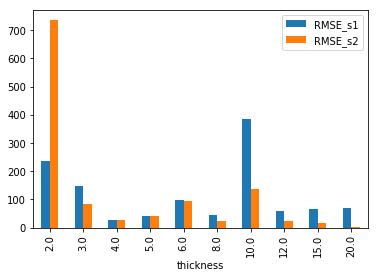

In [44]:
# Is the error sourced by thickness ?
df = comparisonset[['RMSE_s1', 'RMSE_s2', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.show()


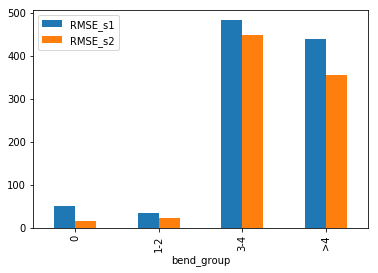

In [45]:
# Is the error sourced by number of errors ?
df = comparisonset[['RMSE_s1', 'RMSE_s2', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.show()
